# Old Car Price Prediction

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor


In [3]:
df = pd.read_csv('car_price.csv', index_col=0)

In [4]:
df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


In [5]:
df.shape

(5512, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5512 entries, 0 to 5511
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   car_name             5512 non-null   object
 1   car_prices_in_rupee  5512 non-null   object
 2   kms_driven           5512 non-null   object
 3   fuel_type            5512 non-null   object
 4   transmission         5512 non-null   object
 5   ownership            5512 non-null   object
 6   manufacture          5512 non-null   int64 
 7   engine               5512 non-null   object
 8   Seats                5512 non-null   object
dtypes: int64(1), object(8)
memory usage: 430.6+ KB


In [7]:
df.describe()

,manufacture
count,5512.000000
mean,2015.455552
std,3.927974
min,1995.000000
25%,2013.000000
50%,2016.000000
75%,2018.000000
max,2022.000000


In [8]:
df.isnull().sum()

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

In [9]:
df['engine'].value_counts()

engine
1197 cc    714
1248 cc    395
998 cc     346
1498 cc    252
1497 cc    245
          ... 
5000 cc      1
2360 cc      1
909 cc       1
2197 cc      1
2979 cc      1
Name: count, Length: 139, dtype: int64

We have lots of values that could be numerical but are stored as strings. We will need to convert them to numerical values.

## Data processing

In [10]:
# Convert string prices to float
def convert_price_to_float(price_str):
    if ' Lakh' in price_str:
        price_str = price_str.replace(' Lakh', '')
        price_float = float(price_str) * 100000 # 1 lakh = 100 000 rupees
    elif ' Crore' in price_str:
        price_str = price_str.replace(' Crore', '')
        price_float = float(price_str) * 10000000 # 1 crore = 10 000 000 rupees
    else:
        price_str = price_str.replace(',', '.') # replace comma with dot (1,5 -> 1.5)
        price_float = float(price_str)
    return price_float

df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(convert_price_to_float)
df['car_prices_in_rupee']

0       1003000.0
1       1283000.0
2       1640000.0
3        777000.0
4        515000.0
          ...    
5507    2890000.0
5508    6490000.0
5509    1375000.0
5510    2990000.0
5511    3190000.0
Name: car_prices_in_rupee, Length: 5512, dtype: float64

In [11]:
# Convert kms_driven string to float
def convert_kms_to_float(km_str):
    km_str = re.sub(r'[a-zA-Z]', '', km_str)  # Remove alphabet
    km_str = km_str.replace(',', '')  # Remove comma
    return float(km_str)

df['kms_driven'] = df['kms_driven'].apply(convert_kms_to_float)
df['kms_driven']

0       86226.0
1       13248.0
2       60343.0
3       26696.0
4       69414.0
         ...   
5507    45000.0
5508    29000.0
5509    90000.0
5510    79000.0
5511    42000.0
Name: kms_driven, Length: 5512, dtype: float64

In [12]:
# Convert Seats string to int
def convert_seats_to_int(seats_str):
    seats_str = re.sub(r'[a-zA-Z]', '', seats_str)  # Remove alphabet
    return int(seats_str)

df['Seats'] = df['Seats'].apply(convert_seats_to_int)
df['Seats']

0       5
1       5
2       5
3       5
4       5
       ..
5507    7
5508    5
5509    5
5510    6
5511    5
Name: Seats, Length: 5512, dtype: int64

In [13]:
# Convert engine string to int
def convert_engine_to_int(engine_str):
    engine_str = engine_str.replace(' cc', '')  # Remove cc
    return int(engine_str)

df['engine'] = df['engine'].apply(convert_engine_to_int)
df['engine']

0       1956
1       1330
2       2494
3       1199
4       1199
        ... 
5507    2995
5508    1968
5509    2755
5510    2967
5511    1991
Name: engine, Length: 5512, dtype: int64

In [14]:
df.describe()

,car_prices_in_rupee,kms_driven,manufacture,engine,Seats
count,5.512000e+03,5512.000000,5512.000000,5512.000000,5512.000000
mean,1.160820e+06,63211.888062,2015.455552,1532.299710,5.250726
std,1.970881e+06,41844.131167,3.927974,579.210876,0.720075
min,3.500000e+01,250.000000,1995.000000,0.000000,2.000000
25%,3.150000e+05,33151.750000,2013.000000,1197.000000,5.000000
50%,5.500000e+05,59000.000000,2016.000000,1396.000000,5.000000
75%,1.025750e+06,84265.250000,2018.000000,1950.000000,5.000000
max,1.920000e+07,560000.000000,2022.000000,5950.000000,8.000000


## EDA

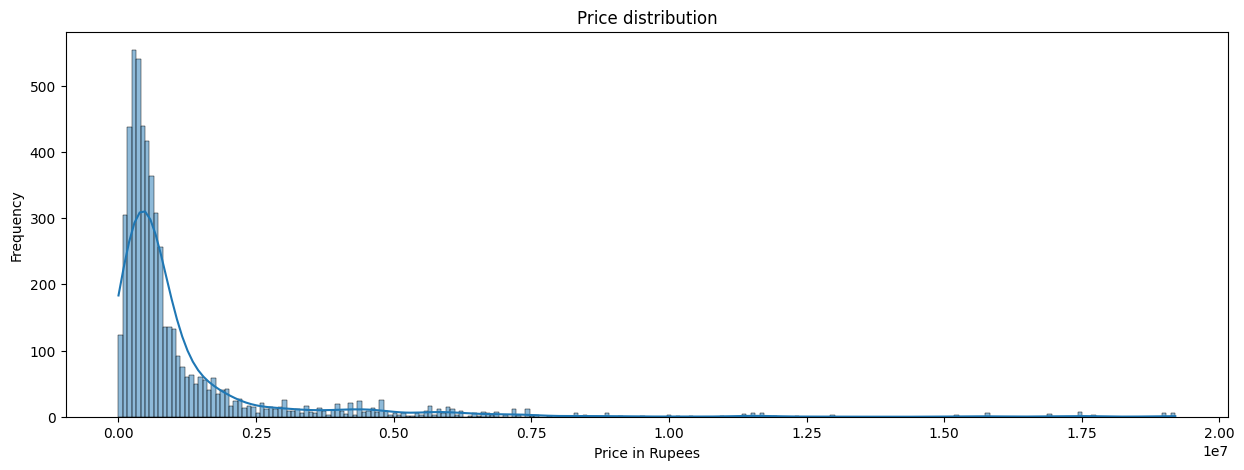

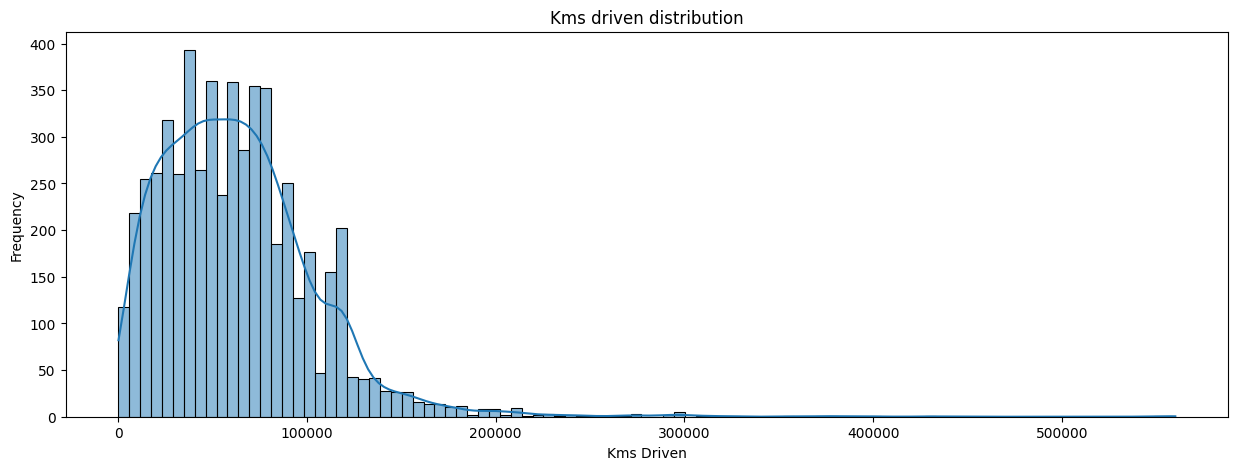

In [15]:
# Plot price distribution
plt.figure(figsize=(15, 5))
sns.histplot(df['car_prices_in_rupee'], kde=True)
plt.title('Price distribution')
plt.xlabel('Price in Rupees')
plt.ylabel('Frequency')
plt.show()

# Plot kms driven distribution
plt.figure(figsize=(15, 5))
sns.histplot(df['kms_driven'], kde=True)
plt.title('Kms driven distribution')
plt.xlabel('Kms Driven')
plt.ylabel('Frequency')
plt.show()

<ipython-input-16-e6af1aad855b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[column_name], palette='viridis')


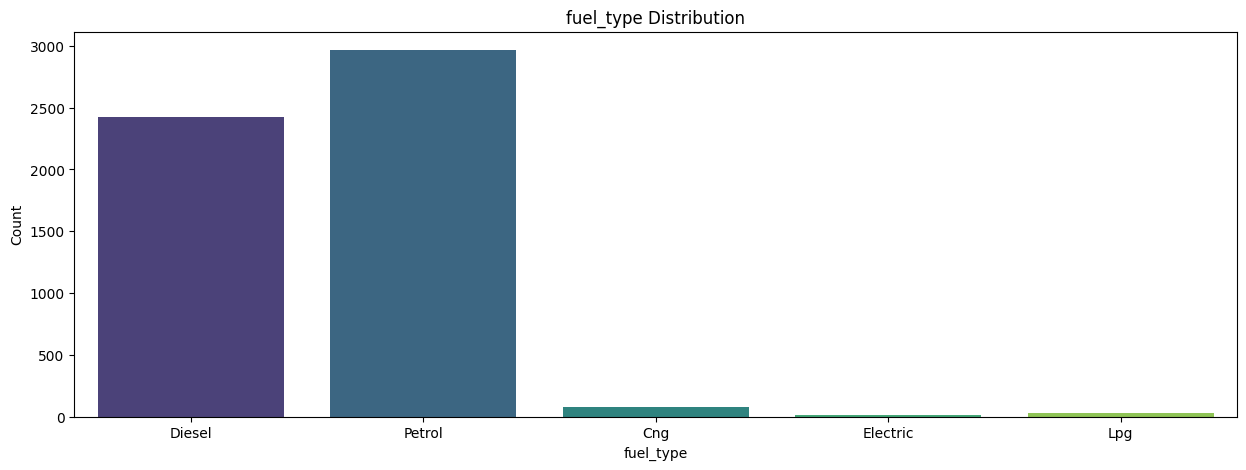

<ipython-input-16-e6af1aad855b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[column_name], palette='viridis')


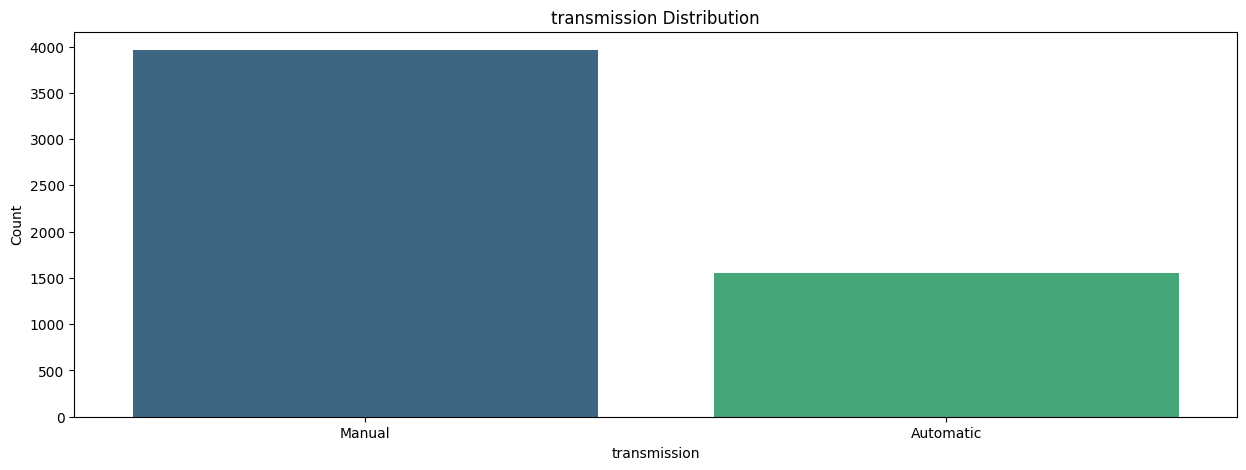

<ipython-input-16-e6af1aad855b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[column_name], palette='viridis')


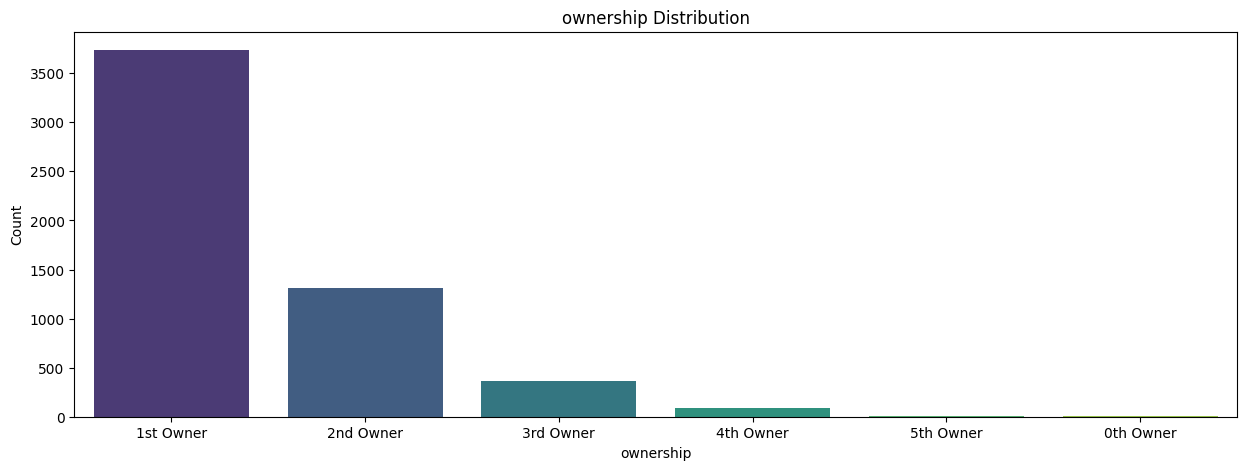

<ipython-input-16-e6af1aad855b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[column_name], palette='viridis')


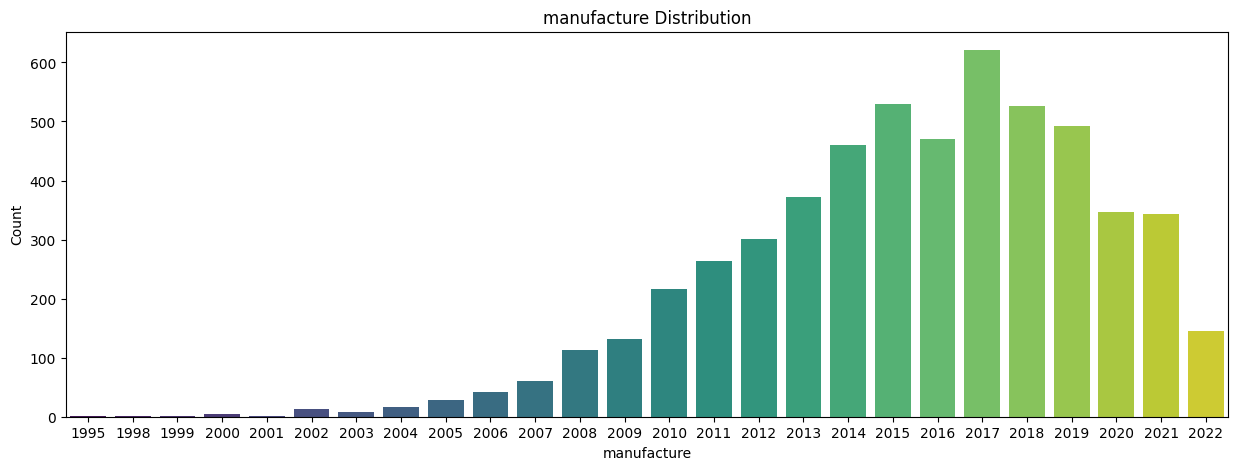

<ipython-input-16-e6af1aad855b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[column_name], palette='viridis')


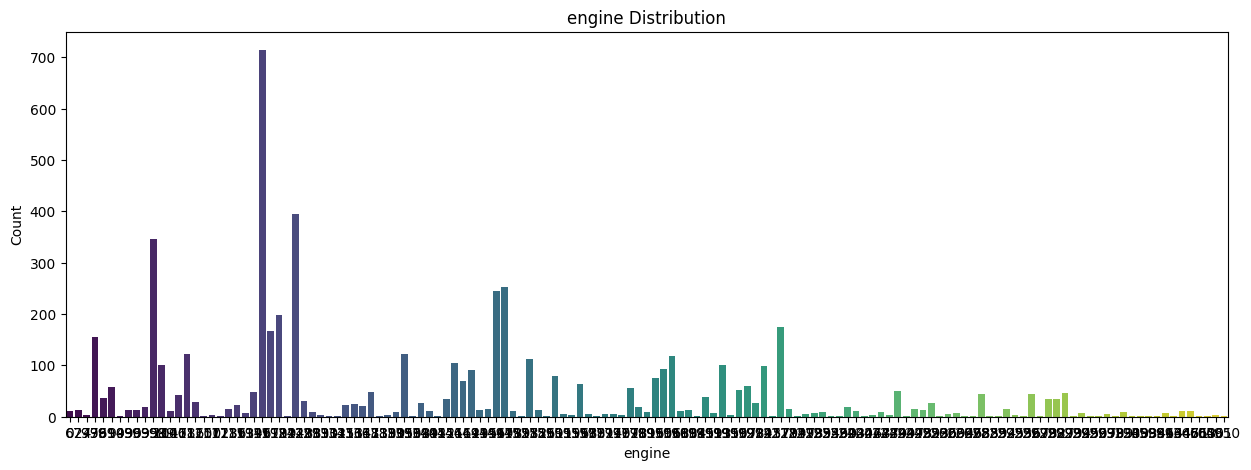

<ipython-input-16-e6af1aad855b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[column_name], palette='viridis')


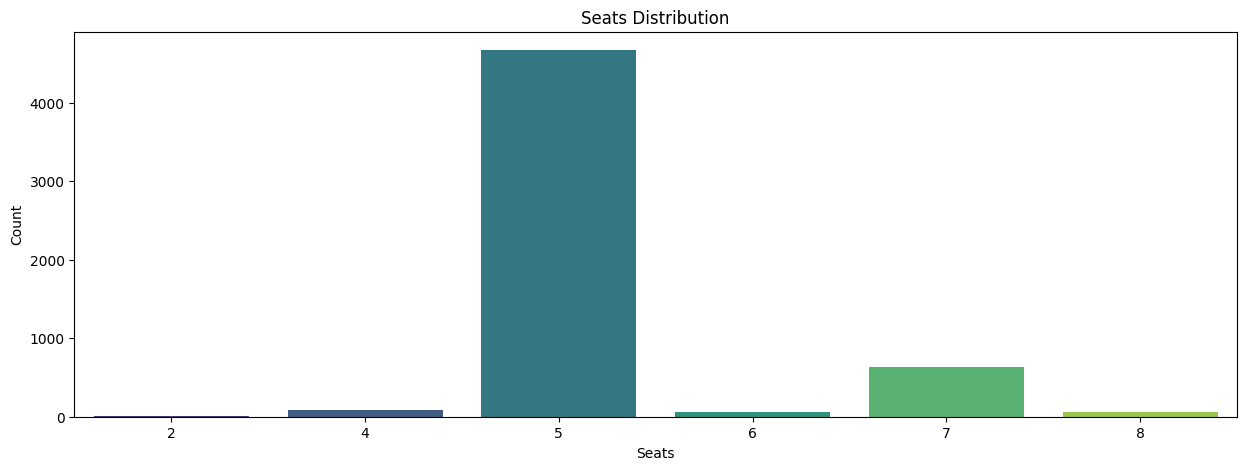

In [16]:
# Function to plot bar plot for categorical columns
def plot_categorical_distribution(df, column_name):
    plt.figure(figsize=(15, 5))
    sns.countplot(x=df[column_name], palette='viridis')
    plt.title(f'{column_name} Distribution')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.show()

# Plotting bar plots for each categorical column
categorical_columns = ['fuel_type', 'transmission', 'ownership', 'manufacture', 'engine', 'Seats']
for col in categorical_columns:
    plot_categorical_distribution(df, col)

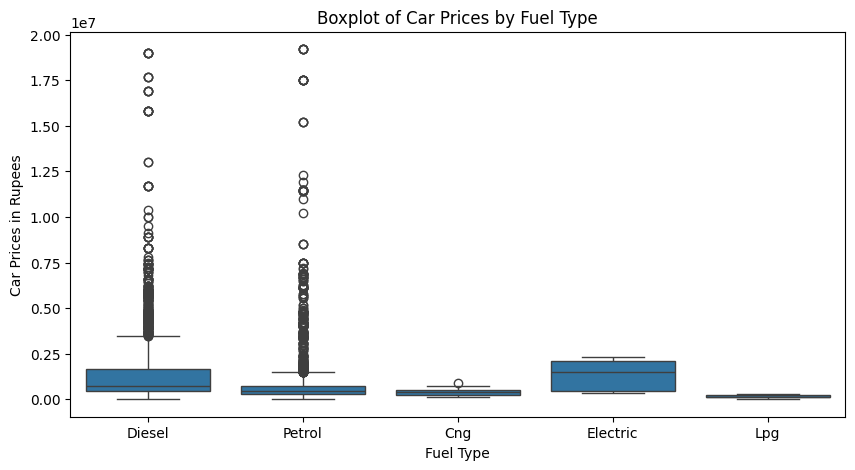

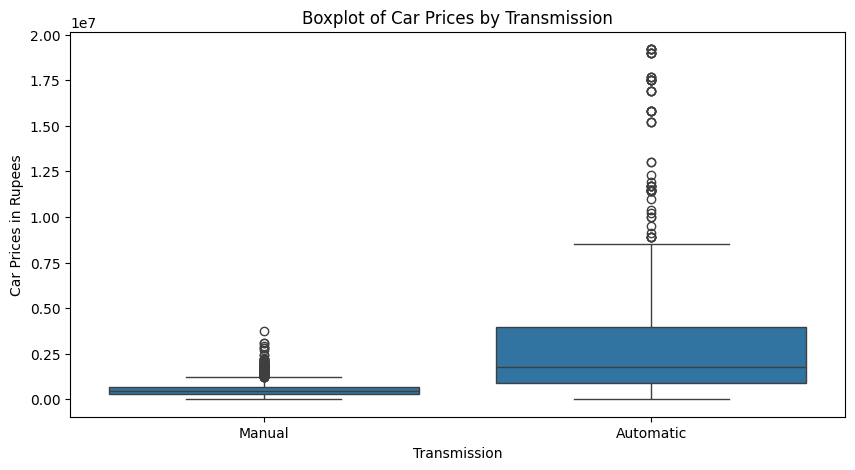

In [17]:
# Boxplots for numerical columns
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['fuel_type'], y=df['car_prices_in_rupee'])
plt.title('Boxplot of Car Prices by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Car Prices in Rupees')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['transmission'], y=df['car_prices_in_rupee'])
plt.title('Boxplot of Car Prices by Transmission')
plt.xlabel('Transmission')
plt.ylabel('Car Prices in Rupees')
plt.show()

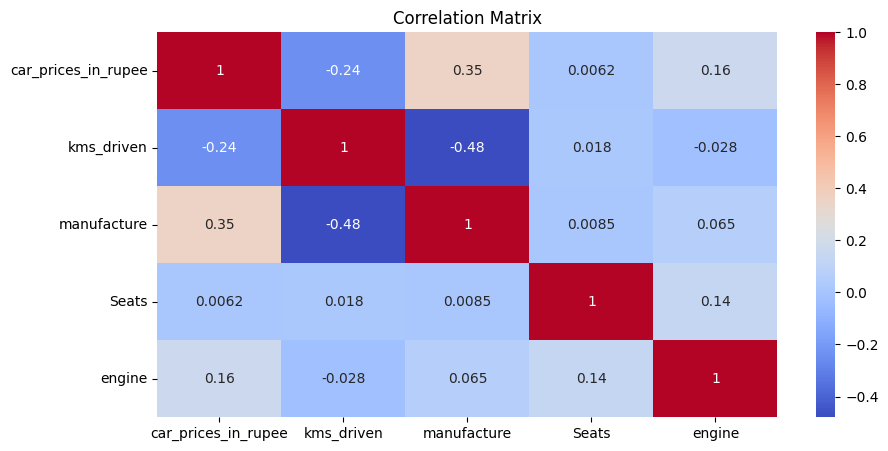

In [18]:
# Correlation matrix
numerical_columns = ['car_prices_in_rupee', 'kms_driven', 'manufacture', 'Seats', 'engine']
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Model training, evaluation and analysis

In [19]:
# Convert non-numerical variables using OneHotEncoder
categorical_features = ['fuel_type', 'transmission', 'ownership']
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_features])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df_encoded = pd.concat([df.drop(categorical_features, axis=1), encoded_df], axis=1)
df_encoded.head()

,car_name,car_prices_in_rupee,kms_driven,manufacture,engine,Seats,fuel_type_Cng,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,fuel_type_Petrol,transmission_Automatic,transmission_Manual,ownership_0th Owner,ownership_1st Owner,ownership_2nd Owner,ownership_3rd Owner,ownership_4th Owner,ownership_5th Owner
0,Jeep Compass 2.0 Longitude Option BSIV,1003000.0,86226.0,2017,1956,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Renault Duster RXZ Turbo CVT,1283000.0,13248.0,2021,1330,5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Toyota Camry 2.5 G,1640000.0,60343.0,2016,2494,5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Honda Jazz VX CVT,777000.0,26696.0,2018,1199,5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Volkswagen Polo 1.2 MPI Highline,515000.0,69414.0,2016,1199,5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['car_prices_in_rupee', 'car_name']), df_encoded['car_prices_in_rupee'], test_size=0.2, random_state=42)

In [21]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

lr_y_pred = lr.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R^2 Score: {lr_r2}')

Mean Squared Error: 2546368066593.9146
R^2 Score: 0.3681724072515512


In [23]:
sgd_reg_constant = SGDRegressor(max_iter=10000, tol=1e-4, learning_rate='constant', eta0=0.01, random_state=42)
sgd_reg_constant.fit(X_train_scaled, y_train)

sgd_y_pred_constant = sgd_reg_constant.predict(X_test_scaled)

sgd_mse_constant = mean_squared_error(y_test, sgd_y_pred_constant)
sgd_r2_constant = r2_score(y_test, sgd_y_pred_constant)

print(f'SGD constant Mean Squared Error: {sgd_mse_constant}')
print(f'SGD constant R^2 Score: {sgd_r2_constant}')
print(f'SGD constant n_iter_ stopping criterion {sgd_reg_constant.n_iter_}')

SGD constant Mean Squared Error: 1.4051247631876158e+22
SGD constant R^2 Score: -3486521088.7166348
SGD constant n_iter_ stopping criterion 6


The maximum number of iterations over the training data (epochs) to perform is set to 10000. The stopping criterion tol is set to 1e-4. The learning rate is set to 0.01. The learning rate is kept constant throughout the training process : eta = eta0

In [24]:
sgd_reg_optimal = SGDRegressor(max_iter=10000, tol=1e-4, learning_rate='optimal', eta0=0.01, random_state=42)
sgd_reg_optimal.fit(X_train_scaled, y_train)

sgd_y_pred_optimal = sgd_reg_optimal.predict(X_test_scaled)

sgd_mse_optimal = mean_squared_error(y_test, sgd_y_pred_optimal)
sgd_r2_optimal = r2_score(y_test, sgd_y_pred_optimal)

print(f'SGD optimal Mean Squared Error: {sgd_mse_optimal}')
print(f'SGD optimal R^2 Score: {sgd_r2_optimal}')
print(f'SGD optimal n_iter_ stopping criterion {sgd_reg_optimal.n_iter_}')

SGD optimal Mean Squared Error: 2646972563134.215
SGD optimal R^2 Score: 0.3432095208163025
SGD optimal n_iter_ stopping criterion 766


Same number of iterations, stopping criterion and learning rate. But the learning rate is set to optimal, which means that the learning rate is determined by the following formula: <br/> eta = 1.0 / (alpha * (t + t0)) where t0 is chosen by a heuristic proposed by Leon Bottou. alpha by default = 0.0001

In [25]:
sgd_reg_invscaling = SGDRegressor(max_iter=10000, tol=1e-4, learning_rate='invscaling', eta0=0.01, random_state=42)
sgd_reg_invscaling.fit(X_train_scaled, y_train)

sgd_y_pred_invscaling = sgd_reg_invscaling.predict(X_test_scaled)

sgd_mse_invscaling = mean_squared_error(y_test, sgd_y_pred_invscaling)
sgd_r2_invscaling = r2_score(y_test, sgd_y_pred_invscaling)

print(f'SGD invscaling Mean Squared Error: {sgd_mse_invscaling}')
print(f'SGD invscaling R^2 Score: {sgd_r2_invscaling}')
print(f'SGD invscaling n_iter_ stopping criterion {sgd_reg_invscaling.n_iter_}')

SGD invscaling Mean Squared Error: 2543567915884.317
SGD invscaling R^2 Score: 0.3688672056608575
SGD invscaling n_iter_ stopping criterion 11


Same number of iterations, stopping criterion and learning rate. But the learning rate is set to invscaling, which means that the learning rate is determined by the following formula: <br/> eta = eta0 / pow(t, power_t) where t is the number of iterations and power_t is set to 0.25 by default.

In [26]:
sgd_reg_adaptive = SGDRegressor(max_iter=10000, tol=1e-4, learning_rate='adaptive', eta0=0.01, random_state=42)
sgd_reg_adaptive.fit(X_train_scaled, y_train)

sgd_y_pred_adaptive = sgd_reg_adaptive.predict(X_test_scaled)

sgd_mse_adaptive = mean_squared_error(y_test, sgd_y_pred_adaptive)
sgd_r2_adaptive = r2_score(y_test, sgd_y_pred_adaptive)

print(f'SGD adaptive Mean Squared Error: {sgd_mse_adaptive}')
print(f'SGD adaptive R^2 Score: {sgd_r2_adaptive}')
print(f'SGD adaptive n_iter_ stopping criterion {sgd_reg_adaptive.n_iter_}')

SGD adaptive Mean Squared Error: 2546203455308.691
SGD adaptive R^2 Score: 0.3682132520742014
SGD adaptive n_iter_ stopping criterion 199


Same number of iterations, stopping criterion and learning rate. But the learning rate is set to adaptive, which means that the learning rate is determined by the following formula: <br/> eta = eta0, as long as the training keeps decreasing. If the training stops decreasing, the learning rate is divided by 5.

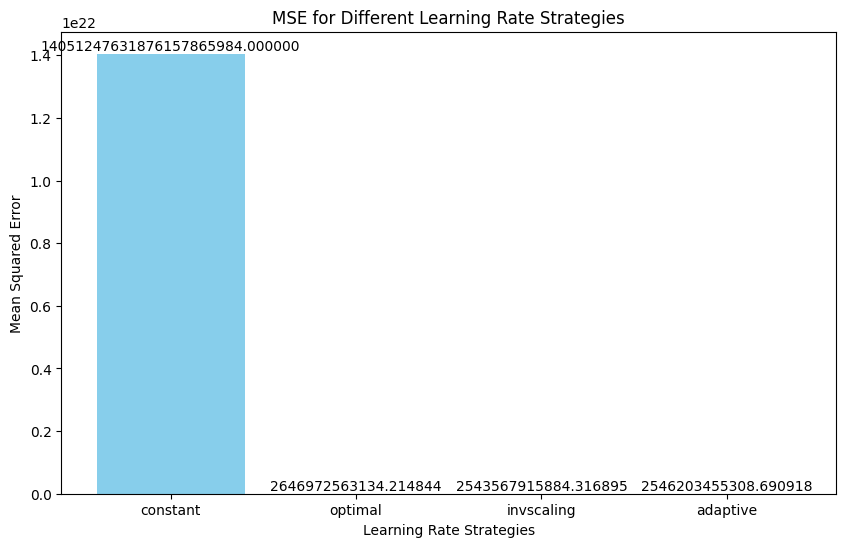

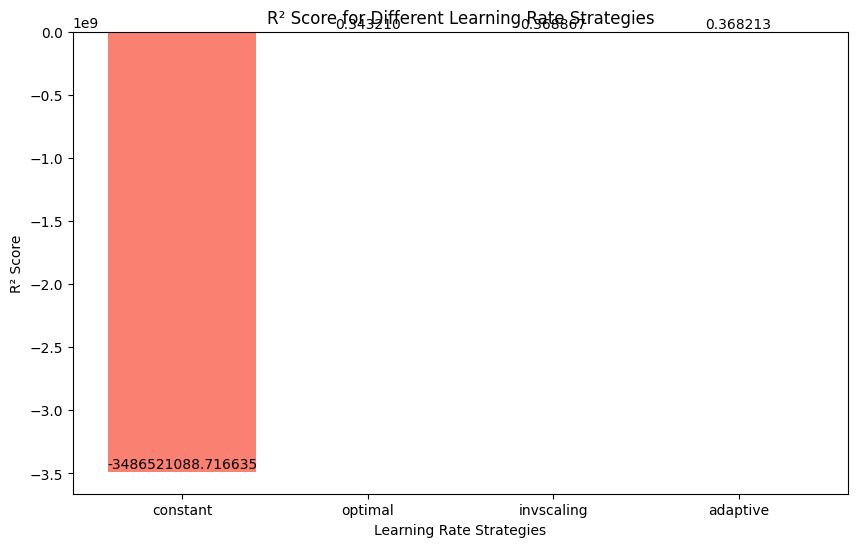

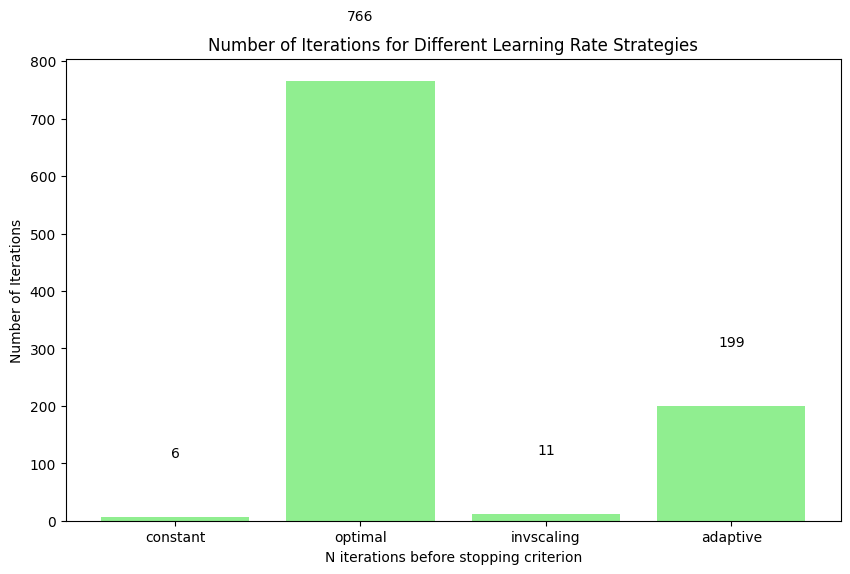

In [27]:
learning_rates = ['constant', 'optimal', 'invscaling', 'adaptive']
mse_scores = [sgd_mse_constant, sgd_mse_optimal, sgd_mse_invscaling, sgd_mse_adaptive]
r2_scores = [sgd_r2_constant, sgd_r2_optimal, sgd_r2_invscaling, sgd_r2_adaptive]
n_iter = [sgd_reg_constant.n_iter_, sgd_reg_optimal.n_iter_, sgd_reg_invscaling.n_iter_, sgd_reg_adaptive.n_iter_]

# Plot MSE scores
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, mse_scores, color='skyblue')
plt.xlabel('Learning Rate Strategies')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Different Learning Rate Strategies')
for i, v in enumerate(mse_scores):
    plt.text(i, v + 0.02, f'{v:.6f}', ha='center', va='bottom')
plt.show()

# Plot R2 scores
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, r2_scores, color='salmon')
plt.xlabel('Learning Rate Strategies')
plt.ylabel('R² Score')
plt.title('R² Score for Different Learning Rate Strategies')
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f'{v:.6f}', ha='center', va='bottom')
plt.show()

# N iterations
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, n_iter, color='lightgreen')
plt.xlabel('N iterations before stopping criterion')
plt.ylabel('Number of Iterations')
plt.title('Number of Iterations for Different Learning Rate Strategies')
for i, v in enumerate(n_iter):
    plt.text(i, v + 100, f'{v}', ha='center', va='bottom')
plt.show()

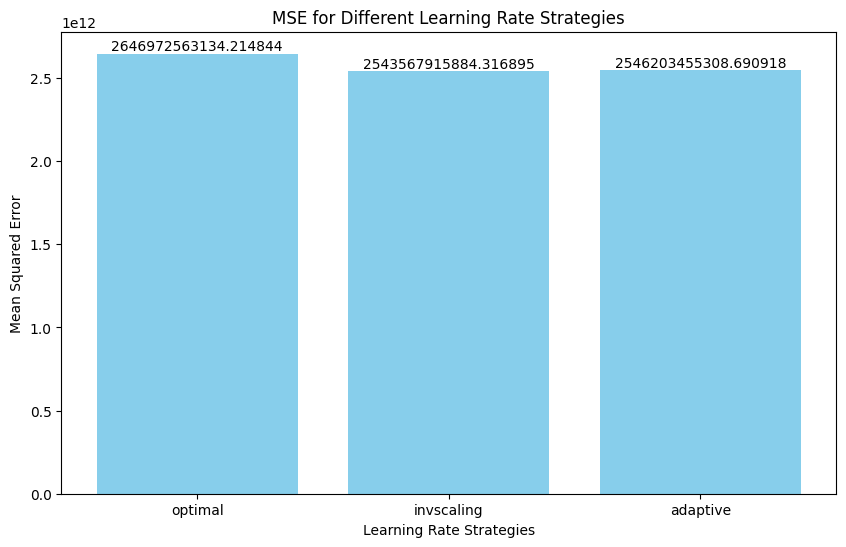

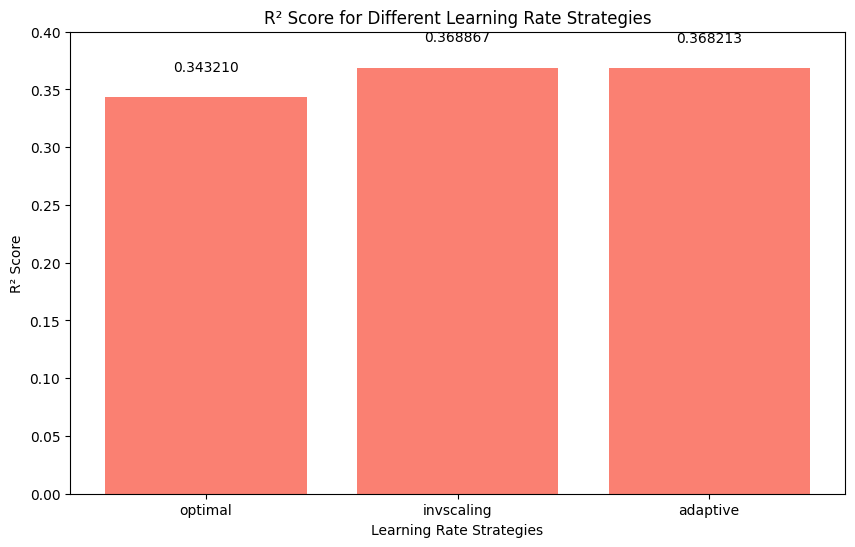

In [28]:
learning_rates = ['optimal', 'invscaling', 'adaptive']
mse_scores = [sgd_mse_optimal, sgd_mse_invscaling, sgd_mse_adaptive]
r2_scores = [sgd_r2_optimal, sgd_r2_invscaling, sgd_r2_adaptive]

# Plot MSE scores
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, mse_scores, color='skyblue')
plt.xlabel('Learning Rate Strategies')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Different Learning Rate Strategies')
for i, v in enumerate(mse_scores):
    plt.text(i, v + 0.02, f'{v:.6f}', ha='center', va='bottom')
plt.show()

# Plot R2 scores
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, r2_scores, color='salmon')
plt.xlabel('Learning Rate Strategies')
plt.ylabel('R² Score')
plt.ylim(0, 0.4)
plt.title('R² Score for Different Learning Rate Strategies')
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f'{v:.6f}', ha='center', va='bottom')
plt.show()

Trying with a lower tolerance as this might be the stopping criterion. tol = 1e-7

In [29]:
sgd_reg_optimal = SGDRegressor(max_iter=10000, tol=1e-7, learning_rate='optimal', eta0=0.01, random_state=42)
sgd_reg_optimal.fit(X_train_scaled, y_train)

sgd_y_pred_optimal = sgd_reg_optimal.predict(X_test_scaled)

sgd_mse_optimal = mean_squared_error(y_test, sgd_y_pred_optimal)
sgd_r2_optimal = r2_score(y_test, sgd_y_pred_optimal)

print(f'SGD optimal Mean Squared Error: {sgd_mse_optimal}')
print(f'SGD optimal R^2 Score: {sgd_r2_optimal}')
print(f'SGD optimal n_iter_ stopping criterion {sgd_reg_optimal.n_iter_}')

sgd_reg_invscaling = SGDRegressor(max_iter=10000, tol=1e-7, learning_rate='invscaling', eta0=0.01, random_state=42)
sgd_reg_invscaling.fit(X_train_scaled, y_train)

sgd_y_pred_invscaling = sgd_reg_invscaling.predict(X_test_scaled)

sgd_mse_invscaling = mean_squared_error(y_test, sgd_y_pred_invscaling)
sgd_r2_invscaling = r2_score(y_test, sgd_y_pred_invscaling)

print(f'SGD invscaling Mean Squared Error: {sgd_mse_invscaling}')
print(f'SGD invscaling R^2 Score: {sgd_r2_invscaling}')
print(f'SGD invscaling n_iter_ stopping criterion {sgd_reg_invscaling.n_iter_}')

sgd_reg_adaptive = SGDRegressor(max_iter=10000, tol=1e-7, learning_rate='adaptive', eta0=0.01, random_state=42)
sgd_reg_adaptive.fit(X_train_scaled, y_train)

sgd_y_pred_adaptive = sgd_reg_adaptive.predict(X_test_scaled)

sgd_mse_adaptive = mean_squared_error(y_test, sgd_y_pred_adaptive)
sgd_r2_adaptive = r2_score(y_test, sgd_y_pred_adaptive)

print(f'SGD adaptive Mean Squared Error: {sgd_mse_adaptive}')
print(f'SGD adaptive R^2 Score: {sgd_r2_adaptive}')
print(f'SGD adaptive n_iter_ stopping criterion {sgd_reg_adaptive.n_iter_}')

SGD optimal Mean Squared Error: 2646972563134.215
SGD optimal R^2 Score: 0.3432095208163025
SGD optimal n_iter_ stopping criterion 766
SGD invscaling Mean Squared Error: 2543567915884.317
SGD invscaling R^2 Score: 0.3688672056608575
SGD invscaling n_iter_ stopping criterion 11
SGD adaptive Mean Squared Error: 2546203455308.691
SGD adaptive R^2 Score: 0.3682132520742014
SGD adaptive n_iter_ stopping criterion 199


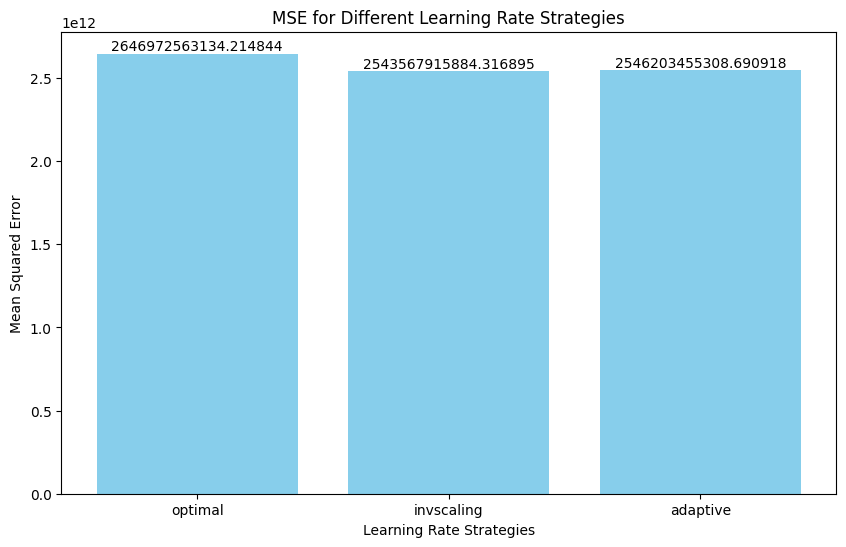

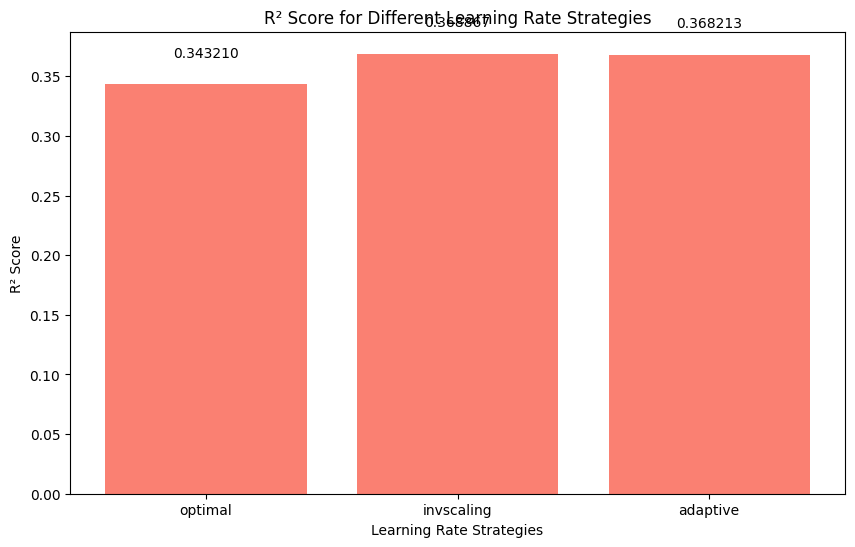

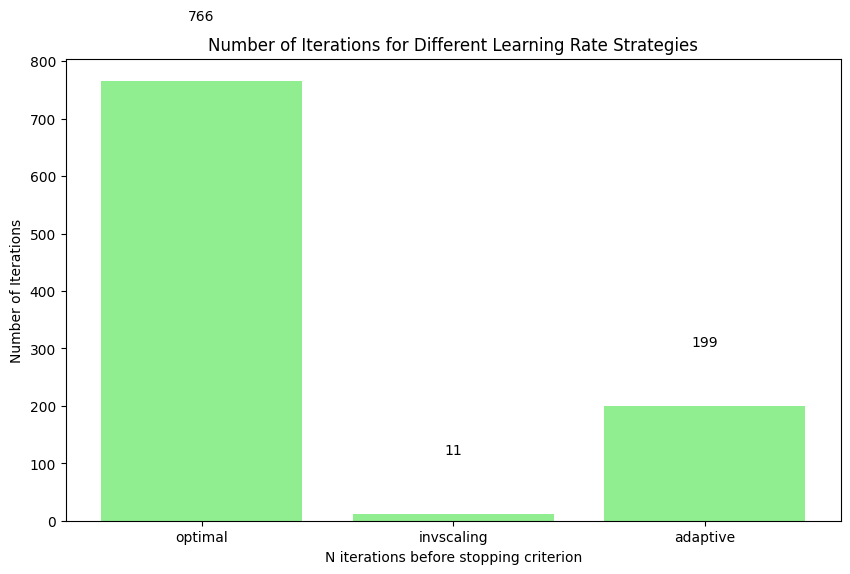

In [30]:
learning_rates = ['optimal', 'invscaling', 'adaptive']
mse_scores = [sgd_mse_optimal, sgd_mse_invscaling, sgd_mse_adaptive]
r2_scores = [sgd_r2_optimal, sgd_r2_invscaling, sgd_r2_adaptive]
n_iter = [sgd_reg_optimal.n_iter_, sgd_reg_invscaling.n_iter_, sgd_reg_adaptive.n_iter_]

# Plot MSE scores
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, mse_scores, color='skyblue')
plt.xlabel('Learning Rate Strategies')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Different Learning Rate Strategies')
for i, v in enumerate(mse_scores):
    plt.text(i, v + 0.02, f'{v:.6f}', ha='center', va='bottom')
plt.show()

# Plot R2 scores
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, r2_scores, color='salmon')
plt.xlabel('Learning Rate Strategies')
plt.ylabel('R² Score')
plt.title('R² Score for Different Learning Rate Strategies')
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f'{v:.6f}', ha='center', va='bottom')
plt.show()

# N iterations
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, n_iter, color='lightgreen')
plt.xlabel('N iterations before stopping criterion')
plt.ylabel('Number of Iterations')
plt.title('Number of Iterations for Different Learning Rate Strategies')
for i, v in enumerate(n_iter):
    plt.text(i, v + 100, f'{v}', ha='center', va='bottom')
plt.show()

Results doesn't change with a lower tolerance. <br/>
It might the early stopping criterion or n_iter_no_change that are stopping the training process before the maximum number of iterations is reached. <br/>
Let's try setting early_stopping to False and n_iter_no_change to 10000 (same value as max_iter).

In [31]:
sgd_reg_optimal = SGDRegressor(max_iter=10000, tol=1e-7, learning_rate='optimal', eta0=0.01, random_state=42, early_stopping=False, n_iter_no_change=10000)
sgd_reg_optimal.fit(X_train_scaled, y_train)

sgd_y_pred_optimal = sgd_reg_optimal.predict(X_test_scaled)

sgd_mse_optimal = mean_squared_error(y_test, sgd_y_pred_optimal)
sgd_r2_optimal = r2_score(y_test, sgd_y_pred_optimal)

print(f'SGD optimal Mean Squared Error: {sgd_mse_optimal}')
print(f'SGD optimal R^2 Score: {sgd_r2_optimal}')
print(f'SGD optimal n_iter_ stopping criterion {sgd_reg_optimal.n_iter_}')

SGD optimal Mean Squared Error: 2541218857574.5156
SGD optimal R^2 Score: 0.3694500749940771
SGD optimal n_iter_ stopping criterion 10000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [32]:
sgd_reg_invscaling = SGDRegressor(max_iter=10000, tol=1e-7, learning_rate='invscaling', eta0=0.01, random_state=42, early_stopping=False, n_iter_no_change=10000)
sgd_reg_invscaling.fit(X_train_scaled, y_train)

sgd_y_pred_invscaling = sgd_reg_invscaling.predict(X_test_scaled)

sgd_mse_invscaling = mean_squared_error(y_test, sgd_y_pred_invscaling)
sgd_r2_invscaling = r2_score(y_test, sgd_y_pred_invscaling)

print(f'SGD invscaling Mean Squared Error: {sgd_mse_invscaling}')
print(f'SGD invscaling R^2 Score: {sgd_r2_invscaling}')
print(f'SGD invscaling n_iter_ stopping criterion {sgd_reg_invscaling.n_iter_}')

SGD invscaling Mean Squared Error: 2544094620931.311
SGD invscaling R^2 Score: 0.36873651489926007
SGD invscaling n_iter_ stopping criterion 10000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [33]:
sgd_reg_adaptive = SGDRegressor(max_iter=10000, tol=1e-7, learning_rate='adaptive', eta0=0.01, random_state=42, early_stopping=False, n_iter_no_change=500)
sgd_reg_adaptive.fit(X_train_scaled, y_train)

sgd_y_pred_adaptive = sgd_reg_adaptive.predict(X_test_scaled)

sgd_mse_adaptive = mean_squared_error(y_test, sgd_y_pred_adaptive)
sgd_r2_adaptive = r2_score(y_test, sgd_y_pred_adaptive)

print(f'SGD adaptive Mean Squared Error: {sgd_mse_adaptive}')
print(f'SGD adaptive R^2 Score: {sgd_r2_adaptive}')
print(f'SGD adaptive n_iter_ stopping criterion {sgd_reg_adaptive.n_iter_}')

SGD adaptive Mean Squared Error: 2546376486478.4434
SGD adaptive R^2 Score: 0.36817031803458256
SGD adaptive n_iter_ stopping criterion 3785


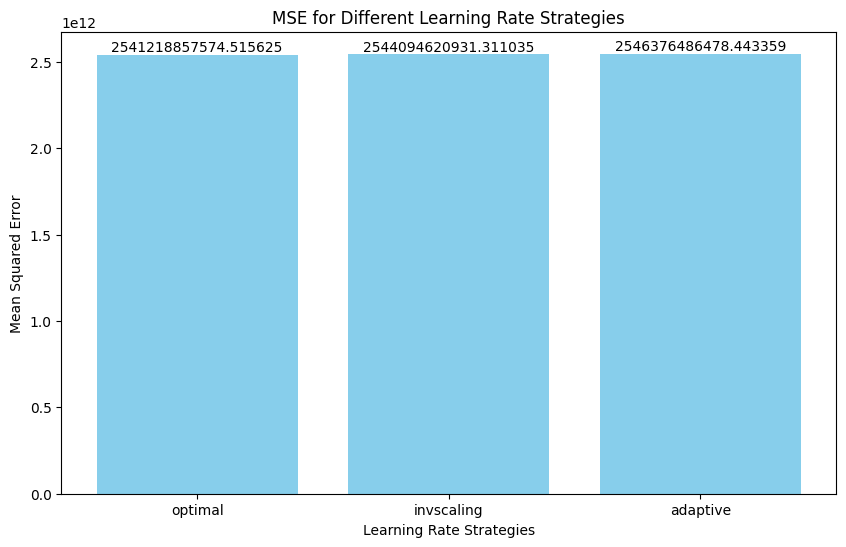

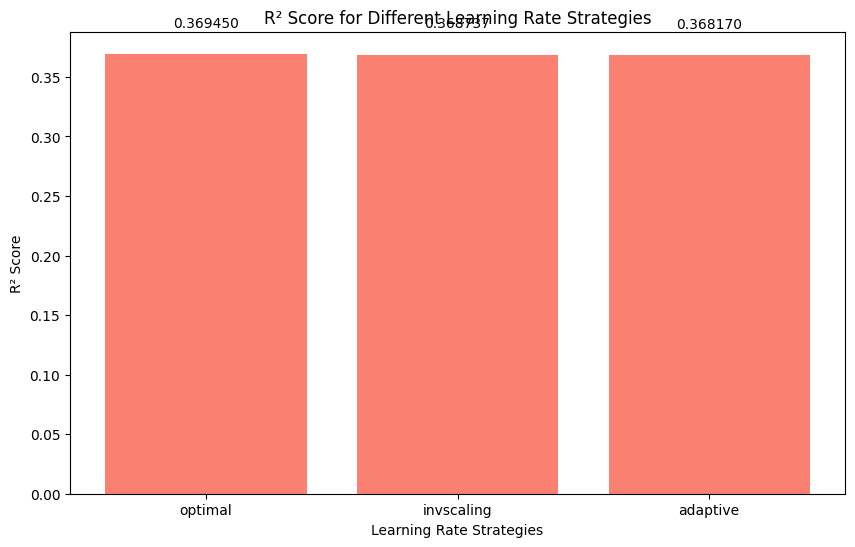

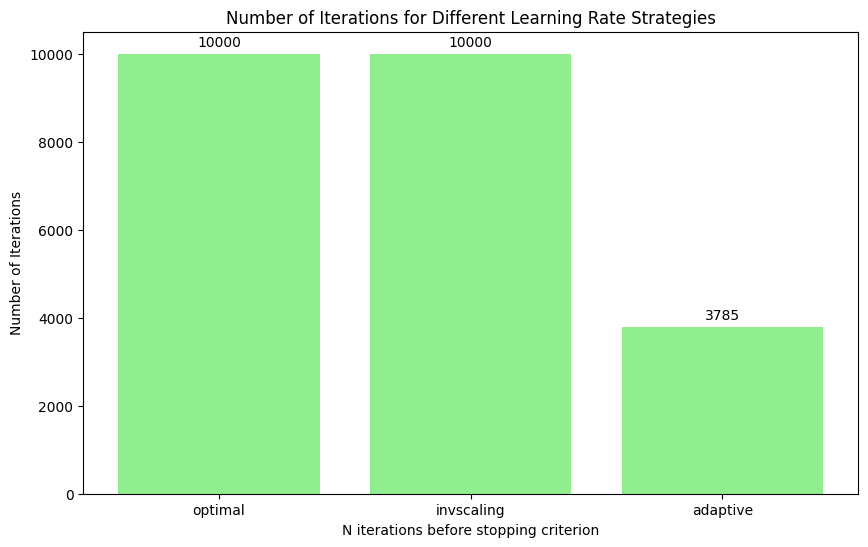

In [34]:
learning_rates = ['optimal', 'invscaling', 'adaptive']
mse_scores = [sgd_mse_optimal, sgd_mse_invscaling, sgd_mse_adaptive]
r2_scores = [sgd_r2_optimal, sgd_r2_invscaling, sgd_r2_adaptive]
n_iter = [sgd_reg_optimal.n_iter_, sgd_reg_invscaling.n_iter_, sgd_reg_adaptive.n_iter_]

# Plot MSE scores
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, mse_scores, color='skyblue')
plt.xlabel('Learning Rate Strategies')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Different Learning Rate Strategies')
for i, v in enumerate(mse_scores):
    plt.text(i, v + 0.02, f'{v:.6f}', ha='center', va='bottom')
plt.show()

# Plot R2 scores
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, r2_scores, color='salmon')
plt.xlabel('Learning Rate Strategies')
plt.ylabel('R² Score')
plt.title('R² Score for Different Learning Rate Strategies')
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f'{v:.6f}', ha='center', va='bottom')
plt.show()

# N iterations
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, n_iter, color='lightgreen')
plt.xlabel('N iterations before stopping criterion')
plt.ylabel('Number of Iterations')
plt.title('Number of Iterations for Different Learning Rate Strategies')
for i, v in enumerate(n_iter):
    plt.text(i, v + 100, f'{v}', ha='center', va='bottom')
plt.show()

We observe a significant improvement in optimal learning_rate but not invscaling. <br/>
The adaptive learning rate model did very bad. That was to be expected since putting n_iter_no_change=10000 means that the learning rate would be constant. <br/>
Let's try adding more iterations to the training process. max_iter=100000

In [35]:
sgd_reg_optimal = SGDRegressor(max_iter=100000, tol=1e-7, learning_rate='optimal', eta0=0.01, random_state=42, early_stopping=False, n_iter_no_change=100000)
sgd_reg_optimal.fit(X_train_scaled, y_train)

sgd_y_pred_optimal = sgd_reg_optimal.predict(X_test_scaled)

sgd_mse_optimal = mean_squared_error(y_test, sgd_y_pred_optimal)
sgd_r2_optimal = r2_score(y_test, sgd_y_pred_optimal)

print(f'SGD optimal Mean Squared Error: {sgd_mse_optimal}')
print(f'SGD optimal R^2 Score: {sgd_r2_optimal}')
print(f'SGD optimal n_iter_ stopping criterion {sgd_reg_optimal.n_iter_}')

SGD optimal Mean Squared Error: 2546268828972.5664
SGD optimal R^2 Score: 0.36819703097670264
SGD optimal n_iter_ stopping criterion 100000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [36]:
sgd_reg_invscaling = SGDRegressor(max_iter=100000, tol=1e-7, learning_rate='invscaling', eta0=0.01, random_state=42, early_stopping=False, n_iter_no_change=100000)
sgd_reg_invscaling.fit(X_train_scaled, y_train)

sgd_y_pred_invscaling = sgd_reg_invscaling.predict(X_test_scaled)

sgd_mse_invscaling = mean_squared_error(y_test, sgd_y_pred_invscaling)
sgd_r2_invscaling = r2_score(y_test, sgd_y_pred_invscaling)

print(f'SGD invscaling Mean Squared Error: {sgd_mse_invscaling}')
print(f'SGD invscaling R^2 Score: {sgd_r2_invscaling}')
print(f'SGD invscaling n_iter_ stopping criterion {sgd_reg_invscaling.n_iter_}')

SGD invscaling Mean Squared Error: 2546217152671.279
SGD invscaling R^2 Score: 0.3682098533622302
SGD invscaling n_iter_ stopping criterion 100000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [37]:
sgd_reg_adaptive = SGDRegressor(max_iter=100000, tol=1e-7, learning_rate='adaptive', eta0=0.01, random_state=42, early_stopping=False, n_iter_no_change=5000)
sgd_reg_adaptive.fit(X_train_scaled, y_train)

sgd_y_pred_adaptive = sgd_reg_adaptive.predict(X_test_scaled)

sgd_mse_adaptive = mean_squared_error(y_test, sgd_y_pred_adaptive)
sgd_r2_adaptive = r2_score(y_test, sgd_y_pred_adaptive)

print(f'SGD adaptive Mean Squared Error: {sgd_mse_adaptive}')
print(f'SGD adaptive R^2 Score: {sgd_r2_adaptive}')
print(f'SGD adaptive n_iter_ stopping criterion {sgd_reg_adaptive.n_iter_}')

SGD adaptive Mean Squared Error: 2546374442320.3145
SGD adaptive R^2 Score: 0.36817082524935907
SGD adaptive n_iter_ stopping criterion 40052


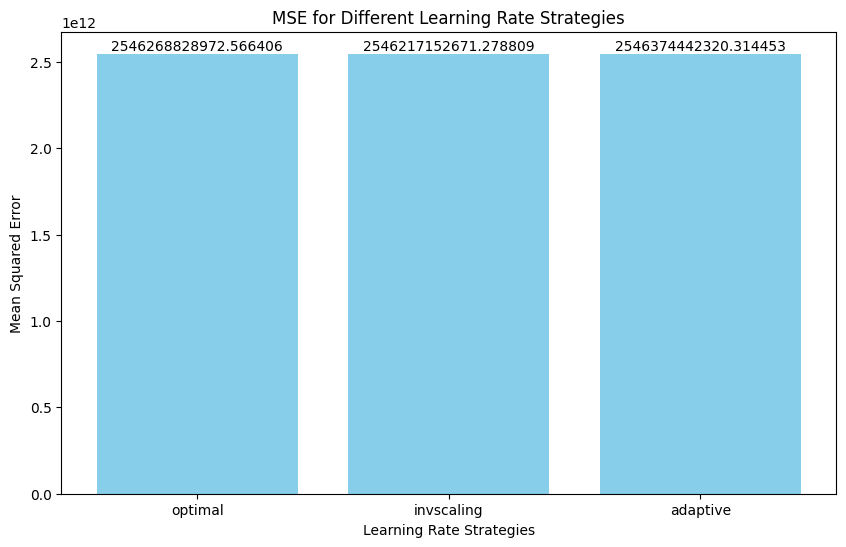

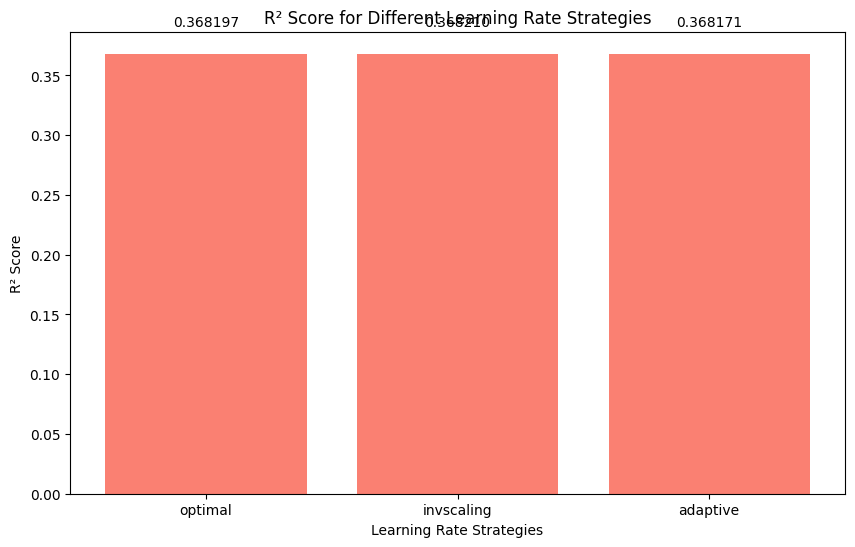

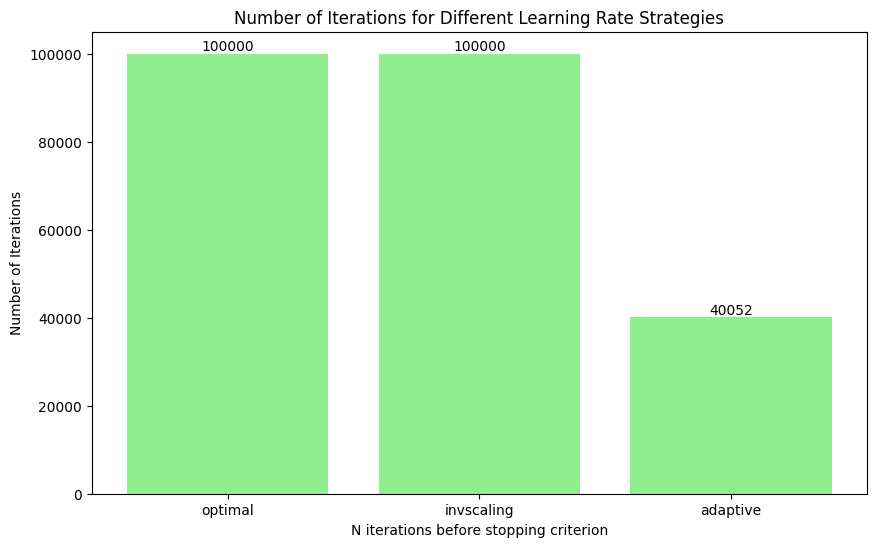

In [38]:
learning_rates = ['optimal', 'invscaling', 'adaptive']
mse_scores = [sgd_mse_optimal, sgd_mse_invscaling, sgd_mse_adaptive]
r2_scores = [sgd_r2_optimal, sgd_r2_invscaling, sgd_r2_adaptive]
n_iter = [sgd_reg_optimal.n_iter_, sgd_reg_invscaling.n_iter_, sgd_reg_adaptive.n_iter_]

# Plot MSE scores
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, mse_scores, color='skyblue')
plt.xlabel('Learning Rate Strategies')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Different Learning Rate Strategies')
for i, v in enumerate(mse_scores):
    plt.text(i, v + 0.02, f'{v:.6f}', ha='center', va='bottom')
plt.show()

# Plot R2 scores
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, r2_scores, color='salmon')
plt.xlabel('Learning Rate Strategies')
plt.ylabel('R² Score')
plt.title('R² Score for Different Learning Rate Strategies')
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f'{v:.6f}', ha='center', va='bottom')
plt.show()

# N iterations
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, n_iter, color='lightgreen')
plt.xlabel('N iterations before stopping criterion')
plt.ylabel('Number of Iterations')
plt.title('Number of Iterations for Different Learning Rate Strategies')
for i, v in enumerate(n_iter):
    plt.text(i, v + 100, f'{v}', ha='center', va='bottom')
plt.show()

## Diving deeper into eta.

In [39]:
n_epochs = 10000
eta0 = 1

### Optimal learning rate

In [40]:
# Set up the SGDRegressor with optimal learning rate
sgd_reg_optimal = SGDRegressor(max_iter=1, learning_rate='optimal', eta0=eta0, random_state=42, early_stopping=False, n_iter_no_change=10000)

# Initialize sgd_reg_optimal to access alpha
sgd_reg_optimal.partial_fit(X_train_scaled[:1], y_train[:1])  # Dummy partial_fit to initialize model parameters

# Estimate t0 based on the initial learning rate and alpha
alpha = sgd_reg_optimal.alpha
t0 = (1 / (eta0 * alpha)) # Estimating t0 based on eta0 and alpha

sgd_reg_optimal_etas = []

for epoch in range(n_epochs):
    sgd_reg_optimal.partial_fit(X_train_scaled, y_train)
    t = sgd_reg_optimal.t_
    eta = 1.0 / (alpha * (t + t0))
    sgd_reg_optimal_etas.append(eta)
    # print(f'Epoch {epoch+1}, Effective eta: {eta:.5f}')


### Invscaling learning rate

In [41]:
# Set up the SGDRegressor
sgd_reg_invscaling = SGDRegressor(max_iter=1, learning_rate='invscaling', eta0=eta0, power_t=0.25, random_state=42, early_stopping=False, n_iter_no_change=10000)

# Track the effective eta
sgd_reg_invscaling_etas = []

for epoch in range(n_epochs):
    sgd_reg_invscaling.partial_fit(X_train_scaled, y_train)
    # Calculate the effective learning rate
    t = sgd_reg_invscaling.t_
    eta = sgd_reg_invscaling.eta0 / (t ** sgd_reg_invscaling.power_t)
    sgd_reg_invscaling_etas.append(eta)
    # print(f'Epoch {epoch+1}, Effective eta: {eta:.5f}')

### Adaptive learning rate

In [42]:
# Set up the SGDRegressor with adaptive learning rate
sgd_reg_adaptive = SGDRegressor(max_iter=1, learning_rate='adaptive', eta0=eta0, random_state=42, early_stopping=False)

# Track the effective eta
sgd_reg_adaptive_etas = []
previous_loss = float('inf')
no_improvement_count = 0

for epoch in range(n_epochs):
    sgd_reg_adaptive.partial_fit(X_train_scaled, y_train)
    # Calculate the current loss to determine if there has been an improvement
    current_predictions = sgd_reg_adaptive.predict(X_train_scaled)
    current_loss = mean_squared_error(y_train, current_predictions)
    if current_loss + sgd_reg_adaptive.tol < previous_loss:
        # Improvement, reset counter
        no_improvement_count = 0
    else:
        # No improvement
        no_improvement_count += 1
        if no_improvement_count >= sgd_reg_adaptive.n_iter_no_change:
            # Adjust learning rate according to the adaptive scheme
            sgd_reg_adaptive.set_params(eta0=sgd_reg_adaptive.eta0 / 5)
            no_improvement_count = 0  # Reset counter after adjusting the learning rate

    # Track the effective learning rate
    sgd_reg_adaptive_etas.append(sgd_reg_adaptive.eta0)
    previous_loss = current_loss  # Update previous loss

    # print(f'Epoch {epoch+1}, Effective eta: {eta:.5f}')


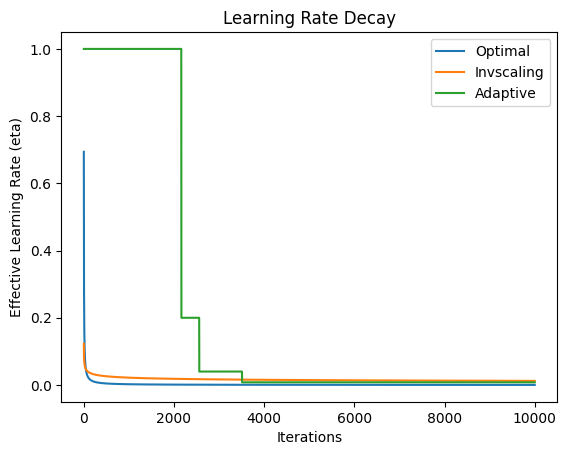

In [43]:
# Plot the effective eta over epochs
plt.plot(range(1, n_epochs+1), sgd_reg_optimal_etas)
plt.plot(range(1, n_epochs+1), sgd_reg_invscaling_etas)
plt.plot(range(1, n_epochs+1), sgd_reg_adaptive_etas)
plt.legend(['Optimal', 'Invscaling', 'Adaptive'])
plt.xlabel('Iterations')
plt.ylabel('Effective Learning Rate (eta)')
plt.title('Learning Rate Decay')
plt.show()

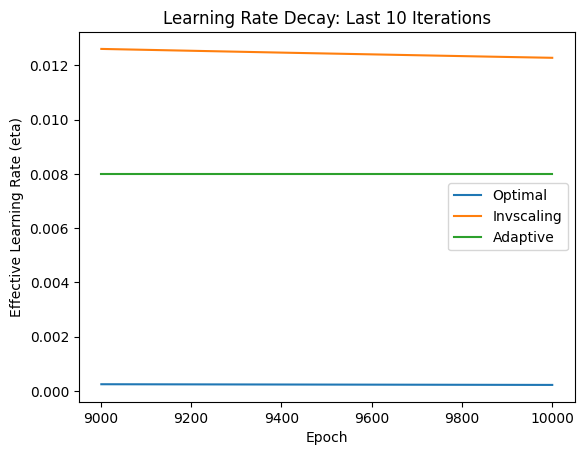

In [44]:
last_n = 1000

# Plot the effective eta for the last n epochs
plt.plot(range(n_epochs - last_n + 1, n_epochs + 1), sgd_reg_optimal_etas[-last_n:])
plt.plot(range(n_epochs - last_n + 1, n_epochs + 1), sgd_reg_invscaling_etas[-last_n:])
plt.plot(range(n_epochs - last_n + 1, n_epochs + 1), sgd_reg_adaptive_etas[-last_n:])

plt.legend(['Optimal', 'Invscaling', 'Adaptive'])
plt.xlabel('Epoch')
plt.ylabel('Effective Learning Rate (eta)')
plt.title('Learning Rate Decay: Last 10 Iterations')
plt.show()


## Neural network with Adam, RMSprop, and SGD

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

In [1]:
def create_model(optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mean_absolute_error')
    return model

In [46]:
# List of optimizers and learning rates
optimizers = ['adam', 'rmsprop', 'sgd']
learning_rates = [0.01, 0.001, 0.0001]

results = {}

for optimizer in optimizers:
    for lr in learning_rates:
        print(f"Training model with {optimizer} optimizer and learning rate {lr}")
        model = create_model(optimizer=optimizer, learning_rate=lr)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

        test_mae = model.evaluate(X_test, y_test, verbose=0)
        results[(optimizer, lr)] = test_mae
        print(f"Test MAE: {test_mae}")

for key, value in results.items():
    print(f"Optimizer: {key[0]}, Learning Rate: {key[1]} - Test MAE: {value}")

Training model with adam optimizer and learning rate 0.01
Test MAE: 826288.6875
Training model with adam optimizer and learning rate 0.001
Test MAE: 824632.3125
Training model with adam optimizer and learning rate 0.0001
Test MAE: 829626.4375
Training model with rmsprop optimizer and learning rate 0.01
Test MAE: 824400.125
Training model with rmsprop optimizer and learning rate 0.001
Test MAE: 827208.9375
Training model with rmsprop optimizer and learning rate 0.0001
Test MAE: 830264.125
Training model with sgd optimizer and learning rate 0.01
Test MAE: 869700.875
Training model with sgd optimizer and learning rate 0.001
Test MAE: 1183497.0
Training model with sgd optimizer and learning rate 0.0001
Test MAE: 869606.0
Optimizer: adam, Learning Rate: 0.01 - Test MAE: 826288.6875
Optimizer: adam, Learning Rate: 0.001 - Test MAE: 824632.3125
Optimizer: adam, Learning Rate: 0.0001 - Test MAE: 829626.4375
Optimizer: rmsprop, Learning Rate: 0.01 - Test MAE: 824400.125
Optimizer: rmsprop, Lear